In [ ]:
import sys
import os
from pathlib import Path

# Это нужно сделать ОДИН РАЗ в начале ноутбука
# Находим корень проекта (на два уровня выше текущей директории ноутбука)
# и добавляем папку src в пути для импорта
project_root = Path.cwd().parent 
src_path = project_root / 'src'
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

from local_paths import RAW_DATA_DIR, FINAL_DATA_DIR
import pandas as pd

folder_name = 'us_stocks'
us_stocks_files = ["train-00000-of-00004.parquet", "train-00001-of-00004.parquet", "train-00002-of-00004.parquet", "train-00003-of-00004.parquet"]


df_list = []
for file in us_stocks_files:
    df_part = pd.read_parquet(RAW_DATA_DIR / folder_name / file)
    df_list.append(df_part)
df_raw = pd.concat(df_list)
df_raw.head()


In [3]:
# Дообогащаем данные
import numpy as np
from datetime import timedelta  # Для возраста, если нужно

df = df_raw.sort_values(['symbol', 'date']).reset_index(drop=True)
df['date'] = pd.to_datetime(df['date'])

# Функция для streak detection
def calculate_streaks(group):
    group = group.copy()
    group['prev_close'] = group['close'].shift(1)
    group['direction'] = np.where(group['close'] > group['prev_close'], 1,
                                  np.where(group['close'] < group['prev_close'], -1, 0))
    group['up_streak'] = group.apply(lambda row: 1 if row['direction'] == 1 else (row['up_streak'] + 1 if pd.notna(row['up_streak']) else 0) if row['direction'] == 1 else 0, axis=1)
    # Лучше vectorized версия:
    group['is_up'] = (group['direction'] == 1).astype(int)
    group['up_streak'] = group['is_up'].groupby((group['is_up'] != group['is_up'].shift()).cumsum()).cumsum()
    group['is_down'] = (group['direction'] == -1).astype(int)
    group['down_streak'] = group['is_down'].groupby((group['is_down'] != group['is_down'].shift()).cumsum()).cumsum()
    return group.drop(['prev_close', 'direction', 'is_up', 'is_down'], axis=1)

# Groupby и transform для эффективности
def enrich_features(group):
    # Rolling stats на 'close'
    windows = [3, 7, 14, 30, 60]
    for w in windows:
        group[f'close_mean_{w}d'] = group['close'].rolling(window=w, min_periods=1).mean()
        group[f'close_std_{w}d'] = group['close'].rolling(window=w, min_periods=1).std()
    
    # Volume mean
    group['volume_mean_7d'] = group['volume'].rolling(7, min_periods=1).mean()
    
    # Log return
    group['log_return_1d'] = np.log(group['close'] / group['close'].shift(1))
    
    # Price range
    group['price_range_1d'] = (group['high'] - group['low']) / group['close']
    
    # Company age (days since first)
    first_date = group['date'].min()
    group['company_age_days'] = (group['date'] - first_date).dt.days
    
    # Streaks (применяем функцию)
    group = calculate_streaks(group)
    
    return group

# Применение: groupby с apply (эффективно для 20M, ~2-5 мин)
df_enriched = df.groupby('symbol', group_keys=False).apply(enrich_features)

# Сохранение (опционально, для 20M — parquet для сжатия)
# df_enriched.to_parquet('enriched_stock_data.parquet', index=False)
print(f"Дообогащено: {len(df_enriched)} строк, новые колонки: {list(df_enriched.columns)}")

/Users/sergei.voronin/Desktop/clean_code/local/rl_stocks/env/ml_env2/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Дообогащено: 24410149 строк, новые колонки: ['symbol', 'date', 'open', 'high', 'low', 'close', 'volume', 'adj_close', 'close_mean_3d', 'close_std_3d', 'close_mean_7d', 'close_std_7d', 'close_mean_14d', 'close_std_14d', 'close_mean_30d', 'close_std_30d', 'close_mean_60d', 'close_std_60d', 'volume_mean_7d', 'log_return_1d', 'price_range_1d', 'company_age_days', 'up_streak', 'down_streak']


/var/folders/g9/58zw5ww16_9f_wywvy8x5qdh0000gp/T/ipykernel_49183/2596262970.py:49: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_enriched = df.groupby('symbol', group_keys=False).apply(enrich_features)


In [7]:
output_name = 'combined.parquet'
# df_df_enrichedraw.to_csv(FINAL_DATA_DIR / output_name)
df_enriched.to_parquet(FINAL_DATA_DIR / output_name)

In [8]:
df_enriched.head()

,symbol,date,open,high,low,close,volume,adj_close,close_mean_3d,close_std_3d,...,close_mean_30d,close_std_30d,close_mean_60d,close_std_60d,volume_mean_7d,log_return_1d,price_range_1d,company_age_days,up_streak,down_streak
0,A,1999-11-18,32.546494,35.765381,28.612303,31.473534,62546380,26.347027,31.473534,NaN,...,31.473534,NaN,31.473534,NaN,6.254638e+07,NaN,0.227273,0,0,0
1,A,1999-11-19,30.713518,30.758226,28.478184,28.880545,15234146,24.176392,30.177039,1.833520,...,30.177039,1.833520,30.177039,1.833520,3.889026e+07,-0.085979,0.078947,1,0,1
2,A,1999-11-22,29.551144,31.473534,28.657009,31.473534,6577870,26.347027,30.609204,1.497063,...,30.609204,1.497063,30.609204,1.497063,2.811947e+07,0.085979,0.089489,4,1,0
3,A,1999-11-23,30.400572,31.205294,28.612303,28.612303,5975611,23.951838,29.655460,1.580200,...,30.109979,1.578301,30.109979,1.578301,2.258350e+07,-0.095310,0.090625,5,0,1
4,A,1999-11-24,28.701717,29.998213,28.612303,29.372318,4843231,24.588066,29.819385,1.482080,...,29.962447,1.406096,29.962447,1.406096,1.903545e+07,0.026216,0.047184,6,1,0


In [9]:
dt_min = df_enriched.date.min().date()
dt_max = df_enriched.date.max().date()
print(dt_min, dt_max)

1962-01-02 2025-12-22


Column: close
Min Value: 0.0
Max Value: 3.000375161263227e+17
Median: 17.600000381469727
StdDev: 621714412830921.0


<Axes: >

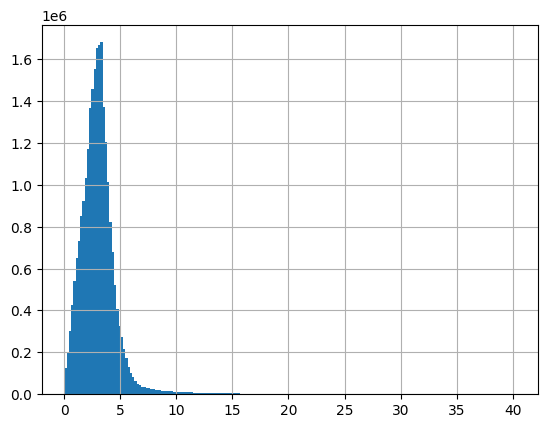

In [10]:
def print_stats(df, target_col):
    print(f"Column: {target_col}")
    print(f"Min Value: {df[target_col].min()}")
    print(f"Max Value: {df[target_col].max()}")
    print(f"Median: {df[target_col].median()}")
    print(f"StdDev: {df[target_col].std()}")
    return

print_stats(df_enriched, "close")

import math

df_enriched.close.apply(math.log1p).hist(bins=200)

In [47]:
companies_stats = df_enriched.groupby('symbol', as_index=False).agg({"close": "max"})
companies_stats['close'] = companies_stats['close'].apply(math.log1p)
print_stats(companies_stats, "close")
companies_stats[companies_stats['close'] >= 10]

# from sklearn.preprocessing import RobustScaler
# scaler = RobustScaler()
# scaler.set_output(transform="pandas") # Позволяет сохранить имена колонок и индексы

# # 4. Fit только на TRAIN, Transform на обоих
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

Column: close
Min Value: 0.001998002757478348
Max Value: 40.242683915502724
Median: 3.9516282688202686
StdDev: 2.319563547595966


,symbol,close
22,ABEO,15.485573
38,ABVC,15.784803
57,ACHV,14.415226
71,ACON,12.883191
109,ADTX,23.566779
...,...,...
6270,XWEL,11.084616
6273,XXII,15.345957
6287,YDKG,10.839601
6314,YYAI,14.739770


/var/folders/g9/58zw5ww16_9f_wywvy8x5qdh0000gp/T/ipykernel_81204/3717902847.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw_rand['date'] = pd.to_datetime(df_raw_rand['date'])


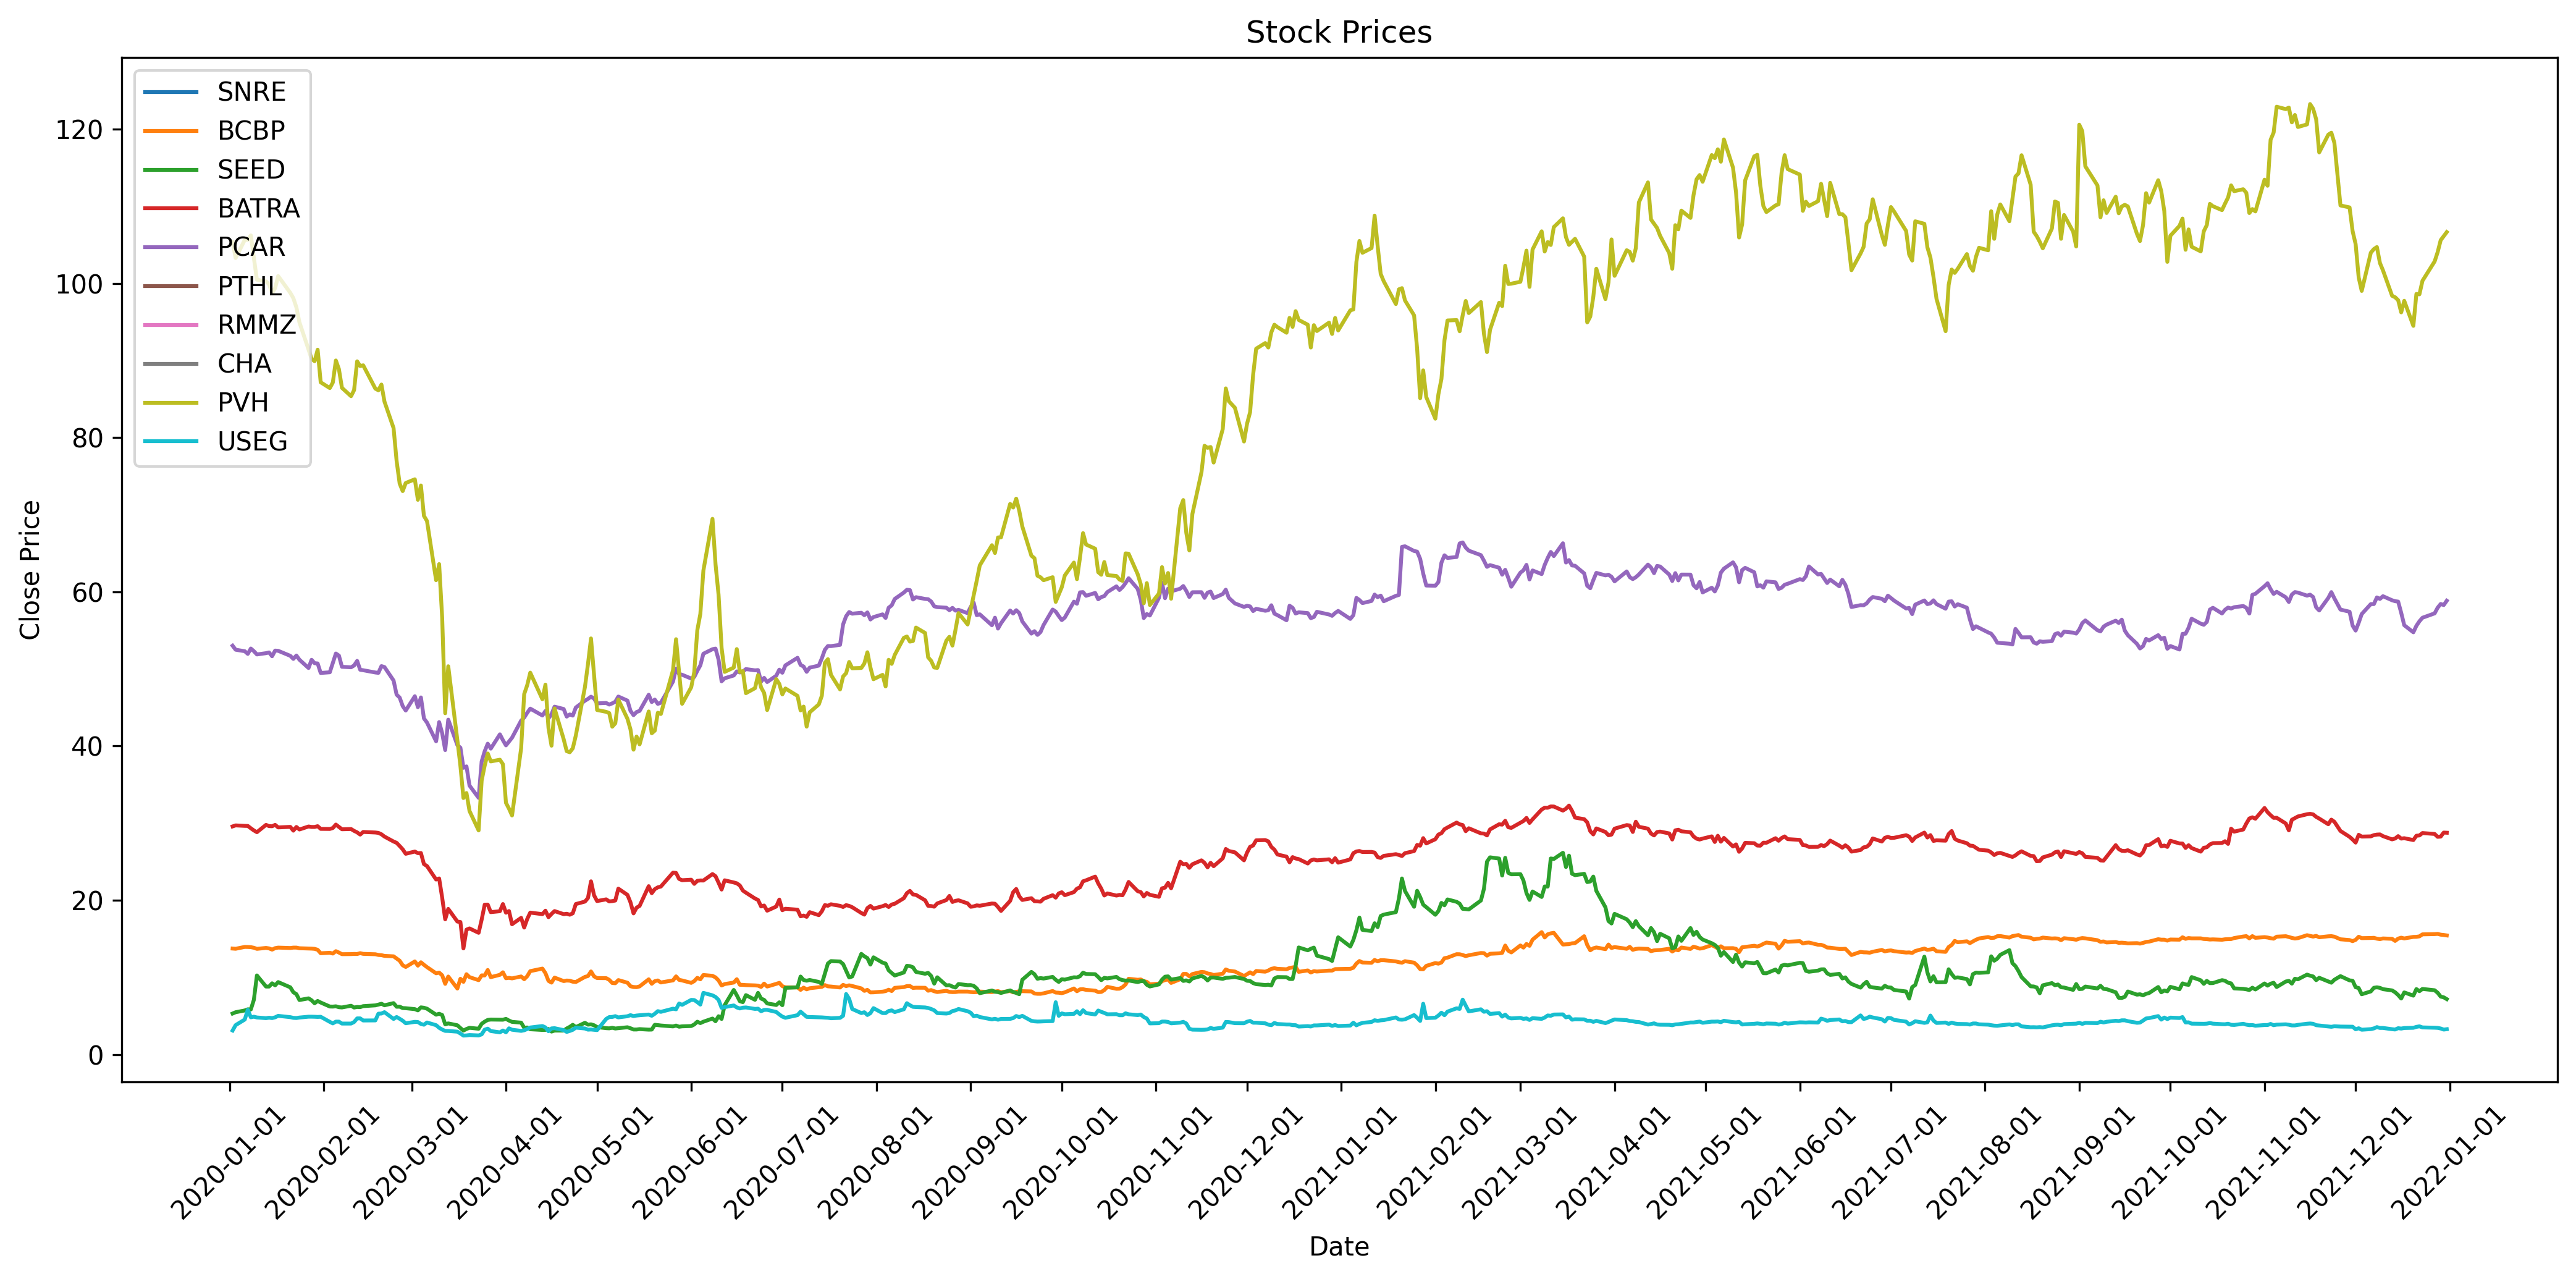

In [15]:
import matplotlib.pyplot as plt
import numpy as np
N_rand = np.random.choice(df_raw.symbol.unique(), size=10, replace=False)
df_raw_rand = df_raw[df_raw.symbol.isin(N_rand)]
df_raw_rand['date'] = pd.to_datetime(df_raw_rand['date'])

plt.figure(figsize=(14, 7), dpi=300)
dates = ['2020-01-01', '2022-01-01']
full_dates = pd.date_range(start=dates[0], end=dates[1])
df_raw_rand = df_raw_rand[df_raw_rand.date >= dates[0]]
df_raw_rand = df_raw_rand[df_raw_rand.date <= dates[1]]
for symbol in N_rand:
    df_symbol = df_raw_rand[df_raw_rand.symbol == symbol]
    plt.plot(df_symbol['date'], df_symbol['close'], label=symbol)
plt.legend()
monthly_ticks = [x for x in full_dates if x.day == 1]  # datetime объекты
monthly_labels = [x.strftime('%Y-%m-%d') for x in monthly_ticks]

plt.xticks(ticks=monthly_ticks, labels=monthly_labels, rotation=45)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Stock Prices')
plt.tight_layout()
# several times showing last date on plot. fix it!

plt.show()